Simulated annealing basically emulates how nature finds the minimum energy state of a system as temperature drops.

We may use this algorithm to find the minimum (or the maximum) of a function stochastically. 

In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

In [341]:
class SimulatedAnnealing:
    def __init__(self, func, dim, region , x0 ,  T0, k, IterationT, MinT, sigma, tol, Nstar, p0,N0,k0):
        '''
        func: the function to be minimized
        
        dim: the number of arguments that func takes
        
        region: the search region
        
        x0: starting point
        
        k: to be used for the temperature update
        
        IterationT: number of iterations per temperature
        
        MinT:  stop when the temperature becomes MinT
        sigma: new neighbours are found between x+N(0,sigma)
        
        tol,Nstar: SA Stops when the acceptance probability is below tol for Nstar successive iterations
        
        To initialize the temperature:
        p0,N0,k0: increase the temperature as T->T*k0 until the acceptance probability is larger that p0
        for N0 successive iterations
        '''
        
        self.func=func
        self.dim=dim
        self.region=region
        self.x=x0
        self.T=T0
        self.k=k
        
        self.IterationT=IterationT
        self.MinT=MinT
        
        #sigma must be smaller than (region[d][1]- region[d][0])*2 
        self.sigma=sigma
        
#         for d in range(dim):
#             if ( self.sigma[d] > (region[d][1]- region[d][0])*2 ):
#                 self.sigma[d] =  (region[d][1]- region[d][0])*2
        
        
        self.tol=tol
        self.Nstar=Nstar
        
        self.p0=p0
        self.N0=N0
        self.k0=k0
        
        self.E=self.func(x0)
        
        #use these to store the abolute minimum. At the end Emin and E should be close.
        self.E_min=self.E
        self.x_min=x0
        self.T0=T0
        
        
        self.ListProb=[]
        self.ListIC=[]
        self.ListE=[]
        self.ListEmin=[]
    
    
    def nextT(self):
        '''Update the temperature'''
#         self.T=self.T/(1+k*self.T)
        self.T*=self.k
        
    # we need the mod function to keep x in the search region in case sigma is too large 
    def mod(self,x,y):
        return float(x) - int(float(x)/float(y)) *float(y)
    def PickNeighbour(self):
        '''Pick a neighbour'''
        x=[]
        for d in range(self.dim):
            x.append(self.x[d] + np.random.rand()*self.sigma[d]-self.sigma[d]/2)
            
            if self.region[d][1]<x[d] :
                dx=x[d]-self.region[d][1]          
                dx=self.mod(dx,self.region[d][1]-self.region[d][0])
                x[d]=self.region[d][0] + dx
                
            if x[d] <self.region[d][0] :
                dx= self.region[d][0] - x[d]
                dx=  self.mod(dx,self.region[d][1]-self.region[d][0]) 
                x[d]= self.region[d][1] - dx

                
        x=np.array(x)
        return x
            
    
    def BoltzmannP(self,Enew):
        '''Given a new value of the energy, return the Boltzmann factor'''
        return np.exp(-(Enew-self.E)/self.T)
    
        
    
    
    def runT(self):
        #use these to find the mean Delta E for a temperature 
        self.AccProb=0
        
        for _ in range(self.IterationT):
            xnew=self.PickNeighbour()
            Enew=self.func(xnew)
            
            #store the abolute minimum you've found so far
            if self.E<self.E_min:
                self.E_min=self.E
                self.x_min=self.x

            
            if Enew<self.E or self.BoltzmannP(Enew) > np.random.rand():
                self.AccProb+=1
                self.E=Enew
                self.x=xnew
                
        self.AccProb=self.AccProb/self.IterationT
    
        
    def InitT(self):
        '''Find an appropriace initial temperature'''
        IterT0=0
        
        while IterT0<self.N0:
            self.runT()
           
            if self.AccProb>self.p0:
                IterT0+=1
            
            if self.AccProb<self.p0 and IterT0>0:
                IterT0=0
            
            self.T*=self.k0
                

        
       
    def run(self, CList=False, restart = False):
        '''
        Iterate until the temperature reaches MinT or until it reaches convergence (Nstart times with AccProb<tol)
        CList=True stores acceptance probabilities, IterConv, E values for all temperatures 
        in self.ListProb self.ListIC, self.ListE
        '''
        if restart:
            self.T=self.T0;
        else:
            self.InitT()
            self.T0=self.T;
        
        IterConv=0
        
        
        
        self.points=[]
        while self.T>self.MinT and self.Nstar>IterConv:
            self.runT()

            if self.AccProb<self.tol:
                IterConv+=1
                self.points.append(self.x)
            
            if self.AccProb>self.tol and IterConv>0:
                IterConv=0
                self.points=[]
            
            
            if CList:
                self.ListProb.append(self.AccProb)
                self.ListIC.append(IterConv)
                self.ListE.append(self.E)
                self.ListEmin.append(self.E_min)
            
            
            
            self.nextT()
            
        self.points=np.array(self.points)
        self.x,self.E= self.x_min,self.E_min
        return self.x,self.E
    
                        

In [342]:
def f(x):
    return x[0]

In [349]:
dim=1
region=[[-1,1] for  _ in range(dim)]

#first run
x0= [0]
k=1-5e-3
T0=np.abs(f(x0))*10+1
IterationT=50
MinT=0#1e-50
sigma=[1e4 for d in range(dim)]
tol=1e-3
Nstar=50

p0=0.8
N0=100
k0=1.1

In [350]:
SA=SimulatedAnnealing(f, dim,region , x0 ,  T0, k, IterationT, MinT,sigma,tol,Nstar,p0,N0,k0)


In [353]:
for i in range(100000):
    x=SA.PickNeighbour()[0]
#     print(x)

0.9462190815029317
0.4041665992945127
1.3470254004614617
0.21771358976457122
1.6258070797375694
1.6636935859705773
0.09061803931263057
1.5588976565795747
0.9938042317198779
1.7629626501893654
0.7355530378908952
1.0433612484448531
0.667616032420483
1.7763181217560486
1.3257603606689372
1.9545087715659974
0.9536689076276161
0.5617892766495061
0.7828637727325258
0.47870598214194615
1.0489387208835979
0.5978647980391543
0.964857186399513
1.0456887173932046
1.2424804153906734
0.4758071871701759
0.04490667943537119
0.041411601905565476
0.35958126435889426
0.9249239785494865
1.9615157402149634
0.35303008051687357
0.9501235859379449
1.301305916263118
1.485384778885873
0.37839424334379146
0.044986686398260645
0.10616035552448011
1.1486896470241845
1.0302427041033297
0.42779039746346825
1.2337913358824153
1.3260740455862106
1.8890100558810445
1.206652472908445
0.9324812205641138
0.5465378019034688
1.582594141997106
1.5965218309120246
1.3037642938270437
0.8971327863400802
0.6562546088571253
1.686

0.5825764600522234
0.4984635198070464
0.703464333319971
0.3494305722720128
1.4067269137649419
1.052358470618401
1.0509283161090934
1.2159769823310853
0.6409441922842234
1.525924050245976
1.1951133557658977
1.4307832625113406
1.766517128002306
0.5514899525160217
1.5127473536749676
1.461913044116045
0.6903279204088903
1.8746375019536572
0.9909060384461554
0.7422179278714793
1.557648443652397
1.4182207836656744
0.8583091295331542
0.3452149275326519
1.7234240816687816
1.899150890943929
0.14419347038074193
0.5027684850347214
1.6877700569875742
0.2979198415969222
0.8306421980487357
1.5929588254957707
1.2578013849770286
0.6239874352650077
0.7161537895754009
0.1284110889373551
1.6947794694297045
1.8715432679828155
0.07728215901533986
0.40801765982905636
0.48388742922452366
0.8881533253484122
0.7818681616772665
1.2614815148717753
0.09075239914545818
0.08384864555500826
1.8907854847670933
0.5751485984683313
1.1597393119782282
1.9938851830847852
0.9982393980835695
1.6427250893721066
1.05947139207

1.1270442914105843
0.6714597297432192
0.7875043952826672
0.8823168605958926
0.821881495994603
1.1988586620400383
1.3817288712416484
0.9459685070796695
0.7687807500515191
0.8930830764520579
1.9781257913036825
0.4167208096137074
0.5560167881249072
0.6754495365976254
1.661444080583351
1.3562985439421027
1.3496213710759548
1.563079124869546
0.34639388021878403
1.2730690120092731
1.1633509252969816
1.9809285144247042
0.44095466679118545
0.4935147808992042
1.3023774955308909
0.2496391248114378
0.5431886356827818
1.50373105997096
1.9236984036015201
1.0113124016152142
0.7454651153266241
1.5075017411154477
0.8561212101822093
1.9505221278059253
0.23935353924298397
1.1062515491084923
0.6436096288307454
0.378657557463157
1.6682950129725214
1.9179980685248665
0.6619534160863623
1.8200146574927203
0.9022827755834442
0.8455475213559112
1.1534519476017522
0.6407366129792536
1.4589152597250177
0.7624832557094123
1.7909106372999304
0.1472833997622729
1.222796253299748
0.696111012081019
1.996256384531989

0.06525338418032334
0.526970441517733
0.12562170355704438
0.7084785144925263
0.38832930607168237
0.8293316765330019
1.5543873727838218
0.9681027250408079
0.9824074695616218
0.14977520735828875
1.2297660684025686
1.7791557576665582
1.0935058678915084
0.5865648228846112
0.9608697640314858
1.731248573438279
1.6386923637155633
0.7979059044728274
0.6171771603430898
1.5212452903315352
0.7411616700319428
1.8394918498152038
1.2765424520002853
0.0007270441046784981
1.9068170190412275
1.4374360567298936
0.6884203859890476
1.8536721917048453
1.4538066481513852
0.2978739924446927
0.9607565063315633
0.34292024457317893
1.1268168659771618
1.4870792265246564
0.4626943307989677
1.851111105520431
0.872412489936778
0.8549491833946377
0.8448403467191383
0.01517011918440403
0.7487856873785859
1.2041429006540056
1.1523669471616813
0.24614360651503375
1.0758279182473416
0.7652096309939225
0.1604848926581326
1.2783716564886163
0.7980895147802585
1.824815821492848
0.18068124241654004
0.47555771337829356
0.709

0.3746013038289675
0.4009827593781665
0.47957800237873016
0.6607153037984972
0.08387086543098121
0.40326605374320934
0.815938675527832
1.3951100294561911
1.246997467494566
1.6894366913147678
1.175258266966921
0.40445986734266626
0.2926161261943889
0.8410042309405981
1.6212221573678107
1.666042966441637
1.407513890944756
0.5767208302795552
1.9383821926203382
1.1050024649739498
0.9781436995608601
0.5998071456615435
1.5410093565342322
1.8366553888413364
1.8787483272026293
1.841281447734218
1.2369943578278253
1.1955651526968722
1.6168544455485971
0.4144575262862418
0.425374124280097
1.9705427088647411
1.8618008922348963
0.20421356168571947
0.02049026199074433
0.3975591033376986
0.4457490375280031
1.7295923459305413
0.3608025953881224
1.6766942304693657
0.17110817940556444
1.7796811651674034
0.3210655192242484
1.621267526588781
1.2213149883032202
1.3568232124753195
0.5666401138223591
0.5151173334215855
1.9596790881523702
1.3871407546675982
1.3008540866062503
0.7181427313680615
0.97218977141

1.1884421216714145
0.7969685975194807
0.2952567139736857
1.3292618907462384
0.15782304362937793
0.8139148034042591
0.8267530739517497
0.7726925287997801
1.9410582826953942
0.9812705384938454
1.8712997335715045
1.1244007615159717
0.22583817058512068
1.4540972318400236
0.16414231712860783
0.6045512470500398
0.317920940690783
1.5566207799192853
0.3807577266370572
0.8550435054348782
0.20593619053033763
1.3239520992010512
0.01109033471038856
1.7500404233901463
1.4059567820349912
0.8582692958334519
1.2284899814885648
0.3455643502402381
0.5883408150980358
0.010410253484224086
1.8085704450913909
0.5723104384142061
0.9257340393105551
1.8549520521628438
1.857244508545591
0.44124381223991804
0.07712686222112097
1.1821071794556701
1.34917601100733
0.2484579511310585
0.5050761355655595
1.6308155036003882
0.3240220821926414
0.039289310366712016
0.09270924324300722
1.8510034265409558
0.5824849000227914
0.9540461595497618
1.5398352748989055
0.9931657648758119
1.3536872431350275
0.11993000118309283
1.9

0.39899703287665034
1.4779509423069612
1.0462936701114813
0.7114923784010898
1.8273240621706464
1.247903011778817
0.5790770079092908
0.47068642954036477
0.2713434949891962
0.8898539546280517
1.5031601534351466
1.5453023585096162
0.0601751700951354
0.3618056871555382
0.2961232384368486
0.6227784435295689
0.5462818664786937
0.17875158125116286
0.539730575829708
0.6334074416108706
0.30755215495446464
1.633368075036742
0.46308096554548683
1.4448703988582565
0.33185713670536643
1.0237917844260664
1.2989547670986212
1.901161553507336
1.4042316538443629
0.3277825522027342
0.872330997390236
0.7054274029769658
0.743015810914585
1.8636114475993963
1.4640112368970222
1.0490697079803795
1.6202953667170732
0.2121363901114819
0.9959706290451322
1.5211966882293382
1.4495743389161362
1.2813439883084357
1.2882444653905623
1.4403487074341683
1.3464214005525719
1.4746770929441482
1.1953703605086048
0.3833618779153767
1.4496677796132644
1.0798072921807034
0.01610685312334681
0.5300936232151798
1.879688348

1.5646361684648582
1.1608074124378618
1.7029569059127425
0.2514704649211126
1.5921585209248406
0.03642404081529094
0.17008060057014518
0.1421565018954425
1.873804972277867
0.3863731917781479
1.6180634879196987
0.46495309664533124
1.2907806639191222
0.909894537638138
0.48024898509902414
0.883937559377955
1.528285001466429
1.074271397933444
1.9278249980834516
0.0907931093552179
0.7539914772287375
0.46744136662528035
1.1712380911949367
0.3089938229895779
1.5641896943589018
1.1920587185441036
0.9822983653284609
0.4955230013674736
1.8865456214862206
1.3856612779018178
0.34130850187102624
1.3593473953487774
1.7347146666652407
0.6002558390018748
0.7987212774833097
1.5816687511414784
0.704210919221623
0.2780684965900946
0.39609652290255326
0.1525994416915637
1.0559313157782526
0.9022387829918443
1.4238917979614598
1.795468161935787
0.9209547698883398
0.6741619027216075
1.4764577398527763
0.8549736460026907
0.6138059940712992
1.3789281718454731
0.5836633075459758
0.18160037812958763
0.615043253

0.8267439177443521
0.9958214298239909
1.7446879444287333
0.9809927358655841
0.6593508799151095
0.8233199054475335
1.4200563174899798
0.0815852063424245
0.891738005240768
1.4565167974906217
0.4231109311349428
1.9862849678283965
1.8136838945156342
0.17154628322987264
1.0622233287567724
1.441647639245275
0.2801668700385562
0.43372005726996576
1.0910569280267737
0.2553268645060598
1.8062392440151598
0.9580063466764841
1.6228893831007554
1.3971218892556863
0.6111874107500626
1.1649334704279681
0.41362546459458827
0.10632832841565687
0.13509835044351348
1.2243964707340638
1.3296783483738182
0.49509019234847074
0.2821807535301559
0.20266029944832553
0.8532981550570184
0.780805563850663
0.8430680268584183
1.7121086658189597
1.572850862769883
0.19685134994915643
1.6978722467902116
0.2004429054522916
1.6769535963248927
1.8762672950260821
0.4481077723976341
1.2921077587161562
1.892645375553002
0.6280307822889881
1.009749441214808
1.6116535685814597
1.5402210893353185
1.5683179076841043
0.57466802

0.8482460893264943
1.8572921062095702
1.4946142427761515
0.11260596200099826
1.3232183690483907
0.3291598742698625
0.6096996320666221
0.8730901471426478
1.0519814809422314
1.4752463997683662
0.2836414066591715
1.2106898220199582
0.17192087114744936
0.35434924013270575
1.2346615306096282
0.838852613369454
1.3477826053585886
1.7117099871966275
1.1128206544217392
0.03365905305236083
1.6602498894690143
0.633841637806654
1.0514563111473763
0.12127474555018125
0.7320938397733698
1.16319995316735
1.7361263050402158
1.2364521265553776
1.908185090022016
1.1434471618986208
0.6439429648071382
1.8511119539889478
0.14022231714716327
0.548654730817816
0.017886295834159682
0.24390689841538915
1.2386021040806554
0.3006346040947392
0.6140208760571113
1.9457711745853885
1.9614526529639988
0.2011708611253198
0.09426945179438917
0.5029347165400395
1.831764829158601
1.9377338331278224
0.6080554826794469
1.6886255809449722
0.17406835672954912
1.4202634923017285
0.7327256068820134
0.10287678931490518
1.51549

0.5935290205470665
1.390048203731567
1.6179786971624708
0.5823316968767358
1.2267174771686769
0.225610559067718
0.7564788778790899
0.7955960725867044
0.49445316795890903
1.85978087541298
1.8766936398615144
0.4216384461715279
1.3456330746989806
1.6321839374704723
0.0951200550662179
1.6760198215383753
0.24898607762224856
0.5839613228808958
1.4702198394916195
0.6129691095684393
1.692864591786929
0.1009676007397502
0.9208462774931832
0.9378012293373104
1.6442446974124323
1.8915588954478153
0.7604587022933629
1.9264528156982124
0.5668842529821632
1.4163202273221032
0.0893907907202447
0.9885115715896973
0.1799999427739749
1.819187432792205
0.717202824938795
1.5295360590880591
0.5940934820009716
1.1362605138956496
1.7038072193745393
1.5959234103966082
0.15945869255256184
0.7535759233769568
1.9964863898785552
1.836647210801857
0.29216906907822704
0.0350366132884119
0.8503361960233633
0.19575613356937538
0.7338841336559199
1.7071402277751986
1.7436087390069588
1.5840305125848317
1.7253971810569

0.3190408340014983
1.8859473490301752
1.11722035276307
0.9335260520356314
0.8439523825327342
1.6586086066790813
0.629717723291833
0.8555119071756963
0.8767642988714215
1.5098552231247595
1.7637088463152395
1.0406630771631171
0.4124889930117206
1.0556117757346328
1.850571897404734
1.6889242775978346
1.0599693658487013
1.965374759722181
0.679667097240781
0.5839693956240808
0.7433008359657833
0.5214950531362774
0.518332662373723
1.3085870309996608
1.3007088948597811
0.18388545742982387
1.4566554862740304
0.8135729029868344
1.3152073641304014
1.0590661851983896
0.6204748832542464
0.6608835660408658
1.6549226895940592
0.5666516037981637
1.4707431521546823
1.1650611770146497
1.7667519989090579
1.8027174077528798
1.2583371514538157
1.5197170913252194
1.4425718725842671
1.4480148974816984
1.7550008945454465
0.4638309049050804
1.1908217960854017
1.2214988131945574
1.9906240316167896
1.7611826964730426
1.2355279041848917
0.32346018756288686
0.5557724558311747
1.6250746277528378
0.139082621628404

0.040872421302992734
0.7059816749015226
1.762491809686253
1.6293895679291381
0.04969053957211145
1.562702674466891
0.2552210042435945
1.1104102378549214
1.5797009317120683
0.9528663896762737
0.5547333596496173
1.4854869757127744
1.7454853914505293
1.3719468064637113
0.7775417231614483
1.9762346738853012
1.6037491266388315
1.2898682045015448
0.021512561196686875
1.7773702019185293
0.5361434454957816
0.58227392988465
1.540860552335289
0.21062858876757673
0.8284737897392915
0.11345020537737582
0.12687881262172596
0.5687683338437637
0.48464873325428925
1.957278157098699
1.0342865367292688
0.7808015048617563
0.7945769108646346
1.5776444233551956
1.3527907618699828
0.7050555716587041
1.0846289346281992
1.0059992003016305
1.6283373855094396
0.007068746250752156
1.3087258379327977
0.502657760159309
1.0863166041981458
0.15128603325638323
0.02191426909848815
0.9068418068964093
1.0060877061478095
1.5229262563379962
1.2905175822215824
1.907114583937073
1.4144671276235385
1.9885424399335534
1.45936

0.5875699185053236
1.5688532044669046
0.6517637009983446
0.3787743285029137
0.22915707048377953
1.9200333382423196
1.5391680094517142
1.804445550357741
0.5253389820272787
0.053899627920600324
0.6512151656406786
1.2489995774776617
0.7553913865212962
1.2279824416677911
0.4043322489342245
1.2539933527341418
1.2137115893037844
0.595683785680194
0.8018303694516362
1.5808458326819164
1.3153776152685168
0.8960867774430881
1.9937830982726155
0.5420766308679958
0.34290669824258657
1.2336129000123037
1.8315543524404347
1.5481505542975356
1.8905498956055453
1.121821390003788
0.44091598567320034
1.7314253170643497
1.907065827255792
0.723459554139481
0.13215981570283475
1.0990835481843533
1.9663707319523382
0.09961538642528467
1.3207915236384906
1.0749769392573398
0.7734981657185926
0.5634399534310433
0.15526281749771442
1.2401092709133081
1.8955365932733912
0.9483414056394395
0.30460096576098294
0.0923155091204535
0.06154196574061643
1.3693546531112588
0.30433853642716713
0.7467659295944031
0.6591

1.669260880093134
1.960896722144298
0.846709610619655
1.4164745725465764
1.8520256172223526
0.2882547071594672
0.13914171710894152
1.7613300848306608
1.3269475043271086
0.30580084857865586
0.39770978656906664
1.0375991261062154
0.27712521782086696
1.199940719130609
1.6947642070417714
0.14744162145780138
1.7689005392876425
1.1545654670971999
0.43413904455064767
0.7634360636884594
0.6913332796311806
1.9098290359825114
1.313943269993615
0.8535303074622789
0.1087539679292604
1.360230377284097
0.3519596179621658
1.7036422276614758
0.36276547823945293
1.6674846462265123
0.6848393301006581
1.5262101804510166
1.5011971337307841
0.3326592400503614
1.5200080286958837
0.2360741960778796
1.0340382277518074
1.1810124615985842
0.11178129518930291
0.16824712580728374
1.1387602380718818
1.190780688896666
0.8672390594183526
1.1565349733837138
0.7191945108252185
1.0209177569749954
0.5159348693550783
1.4824324956180135
1.001020819282985
1.9543653427281242
0.41866424184217976
0.24495520632262924
0.0413050

0.23819754786291014
0.4259882317373922
0.7954253006055296
1.5817208194857812
1.709596300956946
1.563970732740927
1.38617964230707
1.1069832600514928
1.956724221477998
0.570525547897887
0.5106127469434796
1.5884325599290605
1.4198812018894387
1.3292792874426596
0.709406618401772
0.4059769836403575
1.7717924839207626
1.1002495430811905
0.17418791324325866
0.589005973219173
0.256217004471182
1.4819139547380473
1.2373750038841536
0.49512735675853037
0.8333914524555439
0.3121953850713908
1.6847064010344184
1.6058465203832384
0.5334773705453699
1.382564880481823
0.9438795001965445
1.8350803925595756
0.8880972389169983
0.31026249350998114
1.810564182721464
0.7074640186510806
1.8526657313968826
0.7955478980438784
0.3220382930694541
1.3301355143803448
0.6249061298576635
0.8037793703806528
0.28871745558672046
0.03777773515594163
1.7519755554953917
1.8727160850485234
0.8438664025889011
0.44032996817713865
0.24915379548065175
0.7102821874436813
0.5277715071056264
1.9527927008380175
1.9038189302627

1.8149204395899687
0.11526143459559535
1.4144479815249724
0.8689194751705145
0.5305244937680982
1.4953476934242644
1.2262899504885354
1.7157224570864855
0.12527308570406603
1.5547751686162883
1.9302598900212615
0.8396334910285077
1.055521681285427
1.758360644572349
0.7991564737731096
0.4702238167669748
0.054430799587862566
1.7333455781408702
0.010187451469391817
1.9702206200827277
0.4970655021734274
0.8585743250769156
0.801973109402752
1.9563406388269868
1.939136361119381
1.5739864862607647
0.7772934408012588
0.7410105485428176
1.006475832385604
1.214398329915639
0.7365507333433925
1.0579109824252555
0.06391739191712986
1.383803444946352
1.458532513652699
1.248597324882212
1.9957097152037022
0.9961962337365549
1.7981390585428016
0.6979631469112064
0.344433819590904
0.6025791661795665
1.7860603622630151
0.1765751442317196
0.10167145007744693
0.5938287594944995
0.33254566713912936
0.1228254596626357
1.1791163276920997
0.6232904591388433
0.34863401278335004
1.0388895464693633
1.6965825848

0.4061063239455507
0.5072069281668519
1.0579593120237405
0.5690280504263683
1.0788534957819138
1.2348894818660483
1.6229450189257477
0.6252183619108109
1.960459882392115
1.4752238207038317
0.09653690636878309
1.6039845610393968
1.2887464196819565
0.30521792187755636
0.4032003744600843
1.9400148255863314
1.6169985776959948
0.5840227044209314
0.745688485518258
1.4947624739907042
1.4552496401083772
1.759552050863931
0.154692598787733
0.9590828381114989
1.8994984348546495
0.8266885193702365
1.6694783081370588
1.0518228283490316
1.0319037935478264
0.5071067163407861
1.9293246776132946
1.189045296068798
0.5267729402530676
0.9865266880569834
0.3963682290423094
1.58344871286954
0.27468351485322273
1.088495039600275
0.42977828039420274
1.7592893473738513
0.8211456259523402
0.00368081058786629
0.9067197663762272
1.7245197736178852
1.390739651837066
1.877185343824749
0.6078126227694156
0.3884281805749197
0.06299073084846896
0.15315531799660675
0.4412070638700243
0.35492300073565275
1.758093515492

0.6221022936333611
0.14379860315875703
0.8160052284374615
0.5432970080737505
1.6985811013228158
1.4159456624624909
1.0039105312707761
0.880137026578268
0.09566458283461543
0.9617561079739971
0.9595550803014703
0.5368422043775354
0.39791978419907537
0.9851172361522913
0.8338870908200988
1.6733862869068616
0.8994125454191817
0.5404909092649177
1.416403588555113
0.17447001229447778
1.2575629766997736
1.6782822100885824
1.6838577624330355
1.3032828585910465
0.3652385673176468
1.4230538477822847
1.250923578104448
1.4065867209410499
1.0604321785503998
0.9564220425936583
1.565268173782897
1.632968698937475
1.9070534263496484
1.47815937903124
0.6861591472988948
1.2654990388209626
1.3766727421343603
0.4165221495013611
1.0166765338626647
0.7469555837988082
1.9929535726782888
0.06440863999250723
1.2055552600613737
1.3125424649365414
0.8698164221532352
1.8776027877893284
1.5997437500654996
0.9655133410042254
1.6410048774232564
1.2076030679872929
0.899191139766117
0.7220706095877176
0.6142283875979

0.5949334734195872
0.5353319196201483
1.9917629487526938
0.41164567608484504
1.040955696956189
0.6875802781491984
1.2242003814826603
1.4910277105791465
1.7701988188946416
0.41129385045269373
1.9648100215799786
0.5799309243775497
0.7981442827704086
1.5284659577155253
0.3648066880341503
0.07763846565740096
1.0568828805853627
1.2560668535243167
1.643754046939648
1.1671510513569956
1.096836877239184
1.0217998343659929
1.9001759498937645
0.6514431366003919
1.962045498862608
0.2333895601768745
1.82839933546893
1.4044496231454104
0.7765670181461246
0.16468058947975805
1.5777849778523887
0.8375768020905525
1.6381772653430744
1.9997116005069984
0.35406076846584256
1.6631501437605039
0.2027385433057134
1.169783527529944
0.7269684876791871
1.581167295720661
1.1056373221690592
0.4103375487352423
0.6333984197790414
1.1838707312322185
0.6688892330439558
0.5466325011111621
0.7455676420813688
1.3403841268873293
0.28625254882899753
1.1402923579616981
0.25895347711411887
1.946152228218125
1.539370603315

0.5228294374810503
0.3703997457632795
0.7487038763783858
0.07379950982431183
1.1413050431483498
1.7680433522255043
0.5775706391577842
1.4694514715638434
1.6148794396685844
1.2166659821714347
0.9070783984989248
1.673425914857944
1.7957683340705444
0.689427088186676
0.28243615603878425
1.9816488423148257
1.2883727908292713
0.23963694976373517
1.962449844458206
1.4518369801367044
1.459122188940455
1.4178501806450186
1.5672429076275876
1.1838584165034263
1.3657997142363456
0.5093805522801631
0.4785822208432364
0.9978507576570337
1.7091932532807732
0.6592316883779858
0.4495304648257843
1.3078267831815538
1.0955836726225243
1.752375326243964
1.3311359622894088
0.27049336815980496
1.5604327120440757
0.9265551946127744
1.97793027437001
1.4734815175115727
0.5545745252538836
0.39996614276788023
1.3733104496291162
0.5587572539097891
0.8659204133336971
0.5632561920228909
0.285694025176781
0.32376776349974534
1.6380962788934994
0.4774793553769996
1.2581683262960723
0.19805685792061922
1.58033045095

0.6939146638192142
1.3305379466837621
1.8616624926112308
1.8465136884451567
0.4039878346070509
1.5383135619786117
0.4398616486651008
0.04978725959063013
1.9496290472352484
0.8633785697725216
1.3515780094239744
1.4460504808394035
1.2656412782725965
0.8613869208975302
1.706948427228781
1.153713116513245
1.2685681331677188
0.7644081655598711
1.9812607606618258
1.923406089043965
1.7018457195690644
1.6238222861893519
1.8766046948803705
1.3025623080029618
0.9406763844108355
1.1346146631112788
1.905932273783037
0.4787409804866911
1.375666698290388
0.7160136452621373
0.49112180425345286
0.3769539932036423
1.4748797612328417
1.4403935718491994
1.7660339361395927
1.692024142725586
0.9953488466699127
0.283416130923797
1.5048857326328289
1.5819809833819818
0.29669289295361523
1.8659857732445744
1.6464723398403294
1.714058166840914
0.4674821367252662
1.8410668544652253
1.1791410909772821
0.08766573534012423
0.04049672901601298
1.118784578253326
0.27273309978681937
1.869096067080136
1.21447766060282

1.7733427949533507
1.251570003046254
0.7828294095625097
0.47043479309832037
1.6639997306428995
0.028684994562354404
1.5658450243827247
0.38954466989525827
1.0160991859738715
0.29686806533300114
0.8065116740017402
0.5105837617693396
0.6429491445023814
1.367431060572926
0.13773504116579716
1.6310435043233156
0.6872669689919348
1.3038759543051128
0.46951075391461927
1.6167602104105754
0.4767839757314505
1.8525823038417002
1.6361904425157263
1.4886670999640046
1.793077330466076
0.2625721746126146
1.9831943109584245
1.309678629404516
0.23489847230121086
1.8475139297620444
0.5422617481972338
0.45774576506573794
0.6418504213961569
0.995798288979131
0.31274001869769563
1.4008856077148266
1.403774997617802
1.933168374147499
0.3805048299900591
0.21487892176264722
0.582493473912109
1.4164260328852833
1.2606756027980737
0.7939434980089572
0.3118126562330872
1.1355924082890851
0.06268348755838815
0.5868203927484501
1.8663654263195895
0.47361989006549265
0.3895765671541085
1.725933009518485
1.574547

1.3568443637077507
0.6699242600607249
0.5342117121563206
0.6159515501312853
0.04879413117760123
1.869249672045953
0.3974359519779682
1.8938024646067788
0.46312942687836767
0.608674377238458
0.5473267687189036
0.03498172097897623
1.934020669939855
0.3451378074692002
0.456185924120291
1.3498683780799183
0.5935245089749515
0.039047429713718884
1.299210638446766
1.6508197755429137
0.8587155300401719
1.1393929962537186
0.7521943482443021
0.8698912880981879
0.5121699690753303
0.8719600151789564
0.5518764813132293
0.5033884834329001
0.769841309856929
1.6202093448655432
1.957406779939447
1.998158345308184
0.8888997151416334
0.7251397047020873
0.1511980388295342
0.6959909082634113
0.24962022755244107
1.5380703205901227
0.1822892264535767
0.9580364948760689
1.0005142478967173
0.07472707413580792
1.988895772907199
1.0474190335353342
0.10915407617676465
1.922590033303095
0.5202948240489604
1.0708096957132511
0.028426629505247547
0.36917503046788624
0.28834528549668903
1.0275637123222623
0.66805263

0.5842297461358612
0.648269267852811
1.4292479376863412
0.5769174210381607
1.1958642428085113
0.5384734468025272
0.005897887112951139
1.627367291610426
1.4332216705633982
1.6618588421861205
0.3142616744380575
0.07155615370902524
0.6849992332445254
0.8605300746239664
1.5631780674511901
0.9162019942714323
1.2864387157278543
1.8972938230917862
1.7754431080775248
1.5375614277209024
0.6621336392008743
0.1666086047889621
1.9957788586298193
0.8829283018962997
1.8427901388522514
1.6584869853504642
1.3984722037348547
0.1236536584156056
0.715976242537181
0.3244863428717508
1.7372941436815381
1.639810864532592
0.5877213388903328
0.572970434814124
1.5766731142202843
1.086317976115879
1.7331967512436677
1.0836269739666022
0.7987646924489127
1.7057345748489752
0.3029760451272523
0.9967675188927387
0.2738523274529143
1.0474041654342727
1.780030907209948
1.8596815423970838
1.3975464436598486
1.1747569908757214
0.014630356717134418
1.632638437939022
1.757504742097808
1.9982769305488546
1.05934058425873

0.7461170923761529
0.8365675800250756
0.27460629597908337
1.4088558858702527
1.5845344887798092
1.4789442662604415
1.2967919594725572
1.1822712058665275
1.880459936357056
1.9578038458985247
1.0266689567897629
0.2616218487282822
1.9488360763716628
0.7759689339463876
0.46044752646594134
1.1581378393311752
0.6799427452097007
0.7659464692133042
0.775235897499897
1.8249784736217407
1.1742030952582354
0.4451148301777721
0.4889947606243368
0.2211945342251056
0.5918951519420261
1.359130760593871
0.01444785621470146
0.20142431281237805
1.5463369139770293
0.6851403844739252
0.5271913141359619
1.6896118825934536
0.6478989085203466
0.47965752751679247
1.2890474857194931
0.30912617221065375
1.7669014185967171
1.397822489401733
0.2229896031658427
1.5779575376200228
1.2517083833331526
1.7695727915634052
0.4538219009759814
0.5942119568735507
1.736123267747189
1.646315141373634
0.5562110399805533
0.40999398537860543
0.43542185764727037
1.3738575035185931
1.6531552469332382
1.419149758344247
1.921545906

1.7158071106323405
0.6118258970668649
1.9275759308311535
1.5625914522297535
1.2401957230831613
0.19518050298893286
1.0823813106017042
0.35823861483004293
0.14780990062718047
1.8546975657600342
0.09968416942774638
0.8968895732741657
0.2763131527481164
0.3398649274786294
0.8072647706094358
0.9643097914522514
1.6976957036840759
0.42095070971254245
1.1735166894295617
1.442931420732748
0.41760692022035073
0.11113084846419952
1.6445777460075988
0.4215165517562127
0.9220794127086265
1.1290806274846545
1.435574117028409
1.4805671682543107
0.39158356610278133
0.5367931361415685
1.7967759466991993
0.7717406325637057
0.5227132391223677
0.6318645010433102
0.6646231101913145
0.20767206548589456
1.2129810387177713
0.834168409398444
0.501843994130013
0.20253668572149763
1.1650368271994012
0.8174509631307956
1.610183222300293
0.6344884967602411
1.6454672318977828
1.3651797458051078
0.22741433713144943
1.011681205680361
0.37390081151443155
0.9910174050655769
1.2061046898625136
1.6783726560461218
0.3083

1.864570206679673
0.7748490626217972
0.031450901094103756
1.9158469595167844
1.9847595935848403
0.34544173399854117
1.0468771354280761
1.3525479775134954
1.4265432143492944
1.7798552008580373
1.877219839870122
0.8222642614837241
0.7834742183213166
0.05922519152500172
0.31659014305478195
0.9292561356683109
0.08122165978602425
1.5347370354884333
1.1044247896443267
1.3522498934416944
1.4887497115560109
1.4374948517670418
1.4766156414843863
1.6294440204865168
0.2994434202691991
0.645260925695311
0.17887758590950398
0.4657631699324156
1.4084220219615418
1.7869980764708089
1.5038700211216565
1.0084407478634603
0.9864236255125434
1.1985850031469454
1.9231544326939911
1.3822418611571266
0.5275314313557828
0.4630603329615042
1.0359691627504617
0.8821424285779358
0.40454902425244654
0.6874469516260433
0.45182816764145173
0.7117805859393229
0.0830533649532299
0.9062705127671506
1.2894070793522587
0.5486282986016704
1.0902809287094897
1.689225376188915
1.2473744358258045
0.2742827196061626
1.28550

1.8941874133683996
0.2948699474673049
1.5397014947029675
0.015233289648676873
1.130058215396275
1.5064949869265547
0.5436887886212389
0.5126219482881424
1.472414399653644
1.924496029252623
0.059508756951800024
1.214180706472689
0.8874996467120582
0.5805819113929829
1.5410483666682921
0.15508688144927874
0.9147782194304455
0.22736097622419038
0.3901091076922967
1.7215970234738052
0.01908635996551311
1.1877163089848182
0.4922813830589803
0.0010152256363653578
0.10917018052350613
0.7251823851720474
1.8364229991748289
1.078161343051761
1.444680394884017
0.3825750138985313
1.6825710075236202
0.8774839538727974
1.0621807825123142
1.904064000085782
0.6876817800794015
1.7433032809149154
0.24833799998941686
1.3544544267733727
1.0971555662863466
0.5232493032508501
1.6730063625627736
0.03430783155545214
1.0303179826114501
1.4915537902361393
1.9824220969876478
0.31945037958575995
0.8475467073931213
0.5541937955367757
1.730666667506739
1.0513197637037592
0.49487665039396234
1.5161436489115658
1.935

0.8981737824010452
0.23823195330078306
0.6035927264729253
1.1519650946174806
0.3550405651112669
1.1980305186534679
0.01675064631490386
0.43533737450070475
1.5119463667933815
0.1174443597519712
0.828899241379986
1.8444790840876522
0.6011282669078355
1.1375994016161712
1.8559112525344972
0.4092006056989703
0.9986669811205502
0.16087234260066907
1.0193069551883127
1.0644709217958734
0.24741411603918095
0.8654156617867557
0.8039772778411134
1.0417498091819652
1.3853210980742006
1.4214055998781987
0.0853621038941128
0.0499211902715615
1.9557150078817358
0.9689746999820272
0.987771183861696
0.581228701240434
1.071643793133262
1.7923329500936234
0.017482463210399146
0.3957392540269211
1.3891365161653084
0.6005537556420677
0.5964005764162721
1.934127584257567
0.19296965888315754
1.318612733768532
1.9638625476773086
1.5262904731621347
0.017006665791996056
0.1992766998910156
1.7577928839291417
1.810432070472416
1.2116442100586937
1.00180624807399
0.6876082516832867
1.266892686623578
0.7935162279

0.7447326582441747
1.4872152595235093
0.46851067163424887
0.06509413371213668
0.18962246966202656
1.0665466094269505
1.4333099160621714
0.05314615115094057
0.6847900013053732
0.3968424966442399
0.5049005599976226
1.4865160207709778
0.40005861180361535
0.7682367638440155
1.497937961408752
1.3164399387460435
0.9083150597798522
0.5084840715098835
0.8387132828520407
0.7866442789172652
0.43995664794692857
1.6852895639467533
0.16832013606472174
1.6341168814396951
0.3111375875664635
0.5207919958666025
0.5880632938378767
1.7534639344321477
0.6090570322066924
0.6855549703814177
0.24064793298657605
0.6665388784576862
1.3236247244904007
0.7297708187397802
1.2965493498691103
0.09385200618089584
0.6359698992137055
1.1835555871903125
0.5716464686438485
0.018691244364617887
0.08545466209943697
1.1208142660289013
0.4555544802046825
1.502210523784015
0.5325336655496358
1.017873323025924
1.3905469342198558
1.059440117680424
0.7105068409919113
1.3006362944133798
1.2536041996945642
0.6299412790885981
1.37

0.831460659655022
0.7481564294562304
1.5467267857848128
1.4534005038026407
1.8570042413020929
0.3486295049196997
0.1143089187444275
0.7170355284779362
1.5664737637343933
1.1391205998079386
0.882046135238852
0.19466093466689927
0.485237958892867
0.400336157091715
1.9169483560772278
1.509680428483989
0.8894434877843196
0.18689525988338573
1.089649443547387
1.9255325054773493
1.055515681307952
1.3483500181791896
0.6931002590008575
1.6143877018485
0.8361249037006928
1.7719598568592119
1.6907426872712676
0.9963834194459196
0.40709401616732066
1.8207192559157193
1.3285614686601548
0.7203619188039738
0.6648289018439755
1.2922326725674793
0.11576131305082527
0.1885068493002109
0.7572088086894837
1.6609869594185511
0.3268330774790229
1.9380380760758271
0.5993205840486553
1.9945434140408906
0.1798729610391092
0.7202298557617723
1.7119324406376109
1.74416566738455
0.1725394373488598
1.9482256174560462
1.4704092144033893
1.113607882179167
0.30290686954322155
0.009845684348874784
1.7248625259044275

0.21373015728840983
0.3884992886778491
0.9653655840756983
0.036378799963131314
1.4653871261707536
0.8080344446557319
0.7923164813710173
0.1474358012128505
1.512103190914786
0.5702202958336784
1.1494116446956468
0.9815131920440763
1.2381110629171417
1.2031200181072563
1.4614383917714804
0.165764859578303
1.4105571884028905
1.8062203390190916
1.1397038390905436
0.5437619178219393
1.7168004966524677
1.687068022024505
0.5813033920194357
1.702704407625788
0.8006591840330657
0.5628032989943677
1.5488694984383073
1.0984121508708995
1.5750774605203333
0.2283528126336023
0.09264365106446348
0.5636306675651213
1.6327070844654372
0.9673520035703405
0.6653002550347082
1.048385768337539
1.9310357889607985
1.2450401053674796
1.974075600107426
0.761547965274076
1.3244760645511633
0.8674985738425676
0.815371855342164
1.0460089233206418
0.7409004078153885
1.8731443177102847
1.309040135865871
1.7349766980341883
0.3703836546465027
0.319144473211054
0.813361665092998
1.7901193243797024
1.1349843564375988


0.2463083251095668
1.4375801896276243
1.71023931335003
1.4929288681883008
0.2624035903845652
0.3749140390254979
0.5333317525696657
1.4349248815310602
1.352946516351949
0.5614859274101036
0.10018663242863113
0.9425345682102488
1.4189971879095538
0.6529712004694375
1.5376127505360273
0.5328803457364302
0.7886438973837357
1.863401482046811
1.0997775579398876
1.1579249956093918
0.4404609515049742
0.33074832107195107
0.28788315518158925
1.1060144237280838
0.11313142054677883
1.4098902090936463
1.4417677593055487
1.657826616177772
1.17012068411168
1.5299979519950284
0.025197179186761787
1.4857501590959146
1.2184250032614727
1.6256004096894685
1.766187718733363
1.1294494150502032
1.6520939819652085
1.680908491154696
1.0294928571915989
1.763980789364723
1.7077024117188557
1.4162770298098621
1.3179036573369558
1.7663226020758884
1.3279458660263117
1.9239027671110307
1.1202770436329956
1.4162350660781158
1.397414548033339
1.6217818654240546
1.2772520653161337
0.1442698525365813
1.061145511542690

0.3629783292199136
1.6000390378685552
1.1567808460549713
1.4865382883344864
1.4487951212768166
1.3723054690690333
0.1505109088111567
0.6019996042532512
0.4736469347399179
0.07494783396577986
0.9393345226781094
0.3341455062654859
1.5862448033840337
0.4339520312150853
0.89210245819595
1.8251756637137078
0.9145537779540973
1.3198565232460169
0.05611671601627677
1.2250397268999222
1.9398449025175069
1.612703605292154
1.4249904080006672
1.5403714408703308
1.986381207671002
0.5548967852723763
1.3337958272404649
1.6365816468960475
0.9236166240516468
0.8133142904316628
0.15111817458455334
1.3645143827852735
0.4821024341240445
1.1065839695329487
0.06034692971934419
0.4707464490857092
0.7849007971799438
1.8522223836880585
0.7254174178951871
0.6027560801949221
0.15991824301954694
0.8694741538629387
0.3262839122189689
0.9738912659931884
1.1662989830292645
0.31040663654312084
0.7920084722954925
0.6005387963814428
0.5559160587417864
1.8475512236354916
0.7503652899385997
1.8250774893367634
0.41643883

1.365316718060967
0.4384165685678454
0.7802773694838834
1.117936210901462
0.666497193473333
1.6450727413230197
0.22491801632395436
0.944876141844361
0.30841746158557726
0.5558098500760025
1.3771653026492459
1.201327705645781
1.6038506189888722
1.8669496546872324
0.5958065694794641
1.7255115571115311
1.3427291992029495
0.23576895591031644
1.8346360919204017
0.2949119872228039
0.9108001871791203
1.1109173256913891
1.3701298578434944
0.984290313670499
1.9953007511130636
1.4319934914556143
0.5911457966894886
0.6335802311050429
1.0143496019818485
0.5080233892440447
0.7331916837347308
0.8993125243223403
0.9293144538851266
1.6926225359438831
1.1293693018596969
1.5041844171942103
1.8500611675663095
1.4328763528728814
0.0287491444250918
1.501702089196442
0.43310005806506524
1.58947707396419
1.4389687707985104
0.005124528811847995
1.8972525039544053
1.8141734828377594
1.683559224162309
1.8122305003062138
1.7833042926176859
0.6300046320611727
1.7000937202692512
1.9170964553159138
0.38921211611977

0.32013114715664415
0.48862728684071044
1.1520120046561715
0.2646910790426773
1.9574158705099762
0.3962748488957004
0.1825529784500759
0.02126119248850955
1.2973899505259396
1.703349327932301
1.3214237726278952
0.8126724830908643
0.3334194658091292
0.008707549824976013
0.37852460207022887
1.666168698347974
1.753736394729458
1.952789739574655
1.1932540966290617
0.6245101967597293
1.9536066309565285
1.5837607980993198
1.0427224678405764
0.4018528231963501
0.16199637176168835
0.3289278628772081
1.2965900981967025
1.191131293802755
1.019601225572842
0.7866776890141409
0.029160148339542502
1.019560567507142
0.2693632811228781
1.160278314108382
1.4788229326095461
0.45961175308548263
1.468178263003665
0.2329854914801217
0.7631978816061746
1.9468199698458193
1.0491496367631044
1.401267086329426
1.8667891399345535
1.5069151710858932
1.8389934210254069
0.13831275886286676
1.7822797289563823
0.42310295031802525
0.7966491532406508
1.0443505987277604
0.9982716781833005
1.6191126967059972
1.07379621

1.3347312148503079
0.9484037898027964
0.8855104555277649
1.783559300296929
0.31453977595356264
0.877758469242508
1.450803592932516
1.4701756500053307
0.4588783877370588
1.382741990762952
0.3989877513013198
1.5666780199262575
0.5793469545888001
1.7604802717341954
0.24690473087321152
0.9451373065303414
0.5113202843313047
0.5112409864600522
0.5664155455124273
0.612350204267841
0.7504042891923746
1.0790555458534072
0.7430270605573241
0.040670091617357684
1.2077578218659255
0.11346867331485555
0.4290880810140152
0.8729350742978568
0.8343394731109584
0.03220595207221777
0.6831103331278428
1.8009057356975973
1.5774018810507187
1.7208169889545388
1.8664317636362284
1.552950533594867
1.1599538302775727
1.4391564790303164
1.7805817870248575
1.9951413169155785
0.8557170387834958
0.3261600531250224
1.44714520480602
0.21151365489095042
0.8082947510101803
0.17900565622858267
0.08687713973904465
1.2193922408287108
1.3748453131966016
0.34424808274343377
0.7436425938121829
0.7810221822819585
0.77832626

In [352]:
def f(x):
#     return (x[0]-3)**4+(x[1]-1)**2+(x[2]+50)**2
    return (3-x[0])**2+300*(x[1]-x[0]**2)**2
#     return -np.exp(-(x[0]-1)**2)*np.sin(np.pi*x[0])*5+2
#     return np.sum(x**2)



In [4]:
#a good approach is to run once with a large sigma, and once it 
# converges run with a smaller one starting from the last point
# and a higher temperature.

dim=2
region=[[-10,10] for  _ in range(dim)]

#first run
x0= np.random.rand(dim)*5-2.5
k=1-5e-3
T0=np.abs(f(x0))*10+1
IterationT=50
MinT=0#1e-50
sigma=[1e0 for d in range(dim)]
tol=1e-3
Nstar=50

p0=0.8
N0=100
k0=1.1

SA=SimulatedAnnealing(f, dim,region , x0 ,  T0, k, IterationT, MinT,sigma,tol,Nstar,p0,N0,k0)
print(SA.run(True,False),
      '\n\n T=',
       SA.T)

SA.IterationT=150
SA.k=0.99
SA.sigma=[1e-2 for d in range(dim)]
print(SA.run(True,True),
      '\n\n T=',
       SA.T)




(array([2.99435801, 8.9665797 ]), 7.978361632512282e-05) 

 T= 0.005337164793663675
(array([2.99995721, 8.9997465 ]), 4.943468075515055e-09) 

 T= 1.0691278240493172e-08


<IPython.core.display.Javascript object>


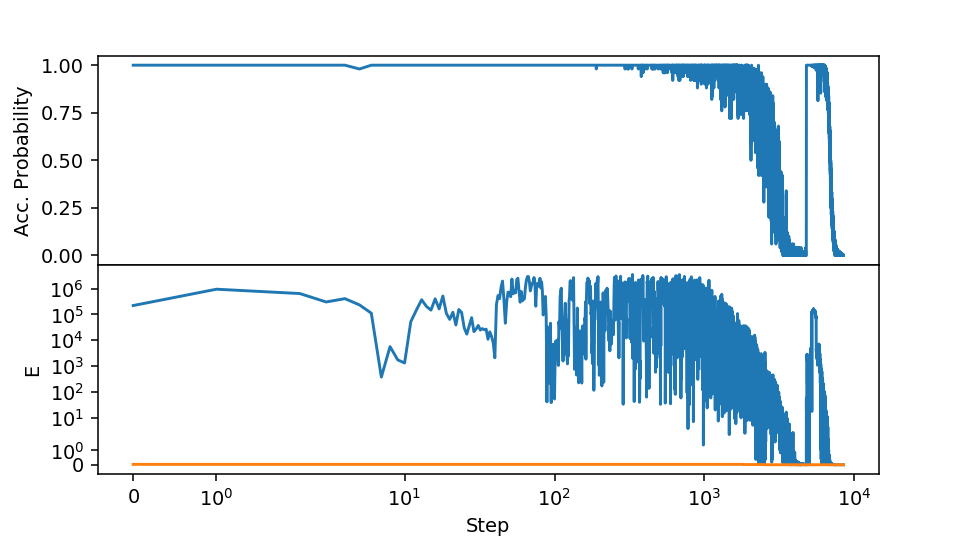

In [5]:
fig=plt.figure(figsize=(7,4))
fig.subplots_adjust(bottom=0.15, left=0.1, top = 0.9, right=0.9,wspace=0.1,hspace=0)
#=============================================================================#


sub = fig.add_subplot(211)
sub.plot(SA.ListProb)

sub.set_xscale('symlog')
# sub.set_yscale('symlog')
sub.set_ylabel('Acc. Probability')
sub.get_xaxis().set_visible(False)


sub = fig.add_subplot(212)
sub.plot(SA.ListE)
sub.plot(SA.ListEmin)

sub.set_xscale('symlog')
sub.set_yscale('symlog')



sub.set_xlabel('Step')
sub.set_ylabel('E')


plt.show()